In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import xgboost as xgb

from tqdm import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split


Populating the interactive namespace from numpy and matplotlib


C:\Users\DNS\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Feature engeneering

Откуда взять признаки?

1) Преобразовать исходные признаки (повороты, вращения, расстояния, переход в другую систему координат; месяцы, дни недели, часы открытия и т.п.; расстояние/время и др.)

2) Создать календарь с праздниками, Черными пятницами, днями голосований и другими важными событиями

3) Подгрузить географические данные: координаты общественных мест, остановок,  аэропортов и т.п.

4) Напарсить чего-нибудь в Интернете: отзывы, цены в каталогах, рейтинги продуктов

5) Найти похожий датасет с новыми фичами


## Работа с текстовыми данными

Как правило, модели машинного обучения действуют в предположении, что матрица "объект-признак" является вещественнозначной, поэтому при работе с текстами сперва для каждого из них необходимо составить его признаковое описание. Для этого широко используются техники векторизации, tf-idf и пр. 


In [4]:
?fetch_20newsgroups

In [5]:
data = fetch_20newsgroups(subset='all', categories=['comp.graphics', 'sci.med'])

In [8]:
len(data['data'])

1963

Данные содержат тексты новостей, которые надо классифицировать на разделы.

In [9]:
data['target_names']

['comp.graphics', 'sci.med']

In [12]:
texts = data['data']
target = data['target']

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

Например:

In [14]:
texts[0]

'From: dyer@spdcc.com (Steve Dyer)\nSubject: Re: Analgesics with Diuretics\nOrganization: S.P. Dyer Computer Consulting, Cambridge MA\n\nIn article <ofk=lve00WB2AvUktO@andrew.cmu.edu> Lawrence Curcio <lc2b+@andrew.cmu.edu> writes:\n>I sometimes see OTC preparations for muscle aches/back aches that\n>combine aspirin with a diuretic.\n\nYou certainly do not see OTC preparations advertised as such.\nThe only such ridiculous concoctions are nostrums for premenstrual\nsyndrome, ostensibly to treat headache and "bloating" simultaneously.\nThey\'re worthless.\n\n>The idea seems to be to reduce\n>inflammation by getting rid of fluid. Does this actually work? \n\nThat\'s not the idea, and no, they don\'t work.\n\n-- \nSteve Dyer\ndyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer\n'

### Bag-of-words (сколько раз слово из словаря входило в данный текст)

Самый очевидный способ формирования признакового описания текстов — векторизация. Пусть у нас имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d.$ В этом случае некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где
$$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

#простой пример
sents = ["dog cat fish", "dog cat cat","fish bird", 'bird']
cv = CountVectorizer()
cv_fit=cv.fit_transform(sents)

In [20]:
cv.get_feature_names().index('cat')

1

In [22]:
# запомнить словарь
vectorizer = CountVectorizer(encoding='utf8')
vectorizer.fit(texts)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [24]:
# один из шагов


Результатом является разреженная матрица.

In [29]:
texts[:1]

['From: dyer@spdcc.com (Steve Dyer)\nSubject: Re: Analgesics with Diuretics\nOrganization: S.P. Dyer Computer Consulting, Cambridge MA\n\nIn article <ofk=lve00WB2AvUktO@andrew.cmu.edu> Lawrence Curcio <lc2b+@andrew.cmu.edu> writes:\n>I sometimes see OTC preparations for muscle aches/back aches that\n>combine aspirin with a diuretic.\n\nYou certainly do not see OTC preparations advertised as such.\nThe only such ridiculous concoctions are nostrums for premenstrual\nsyndrome, ostensibly to treat headache and "bloating" simultaneously.\nThey\'re worthless.\n\n>The idea seems to be to reduce\n>inflammation by getting rid of fluid. Does this actually work? \n\nThat\'s not the idea, and no, they don\'t work.\n\n-- \nSteve Dyer\ndyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer\n']

In [36]:
vec1 = vectorizer.transform(texts[:1])

vec1.toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Задачка:

- Сколько раз встречается самое частое слово в первом тексте?

In [37]:
vec1.shape

(1, 32548)

In [38]:
print(vec1.indices)
print(vec1.data)

[ 3905  3983  4143  4345  4665  4701  4712  5074  5176  5198  5242  5619
  5870  6348  6984  7232  7630  8267  8451  8460  8682  8733  8916  9557
 10811 10812 10901 10933 10971 11312 11488 13133 13226 13463 13866 14726
 14806 15682 15805 15952 16147 18002 18031 18373 18740 18781 18790 18936
 20420 21036 21164 21166 21494 21518 21622 21769 21839 21856 23589 23602
 24556 24592 24803 25502 25513 26464 26474 27021 27398 27518 27940 28199
 28286 28687 29187 29189 29264 29300 29500 29837 30702 31915 32005 32052
 32095 32392]
[2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 6 2 1 2 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 2 1 1 1 2 1 1 1 3 2 1 2 1
 2 3 2 1 3 1 1 2 2 1 1 1]


### TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:

$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Смысл в том, чтобы дать больший вес тем словам, которые характерны для конкретного документа, но не для всех документов вообще.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(encoding='utf8')
vectorizer_tfidf.fit(texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

На выходе получаем разреженную матрицу.

In [42]:
vec2 = vectorizer_tfidf.transform(texts[:1])

<1x32548 sparse matrix of type '<class 'numpy.float64'>'
	with 86 stored elements in Compressed Sparse Row format>

In [43]:
print(vec2.indices)
print(vec2.data)


[32392 32095 32052 32005 31915 30702 29837 29500 29300 29264 29189 29187
 28687 28286 28199 27940 27518 27398 27021 26474 26464 25513 25502 24803
 24592 24556 23602 23589 21856 21839 21769 21622 21518 21494 21166 21164
 21036 20420 18936 18790 18781 18740 18373 18031 18002 16147 15952 15805
 15682 14806 14726 13866 13463 13226 13133 11488 11312 10971 10933 10901
 10812 10811  9557  8916  8733  8682  8460  8451  8267  7630  7232  6984
  6348  5870  5619  5242  5198  5176  5074  4712  4701  4665  4345  4143
  3983  3905]
[0.02775776 0.030364   0.10357777 0.10097852 0.05551552 0.08913878
 0.0751644  0.05521512 0.02543534 0.07527191 0.05440145 0.04646966
 0.07125018 0.0955189  0.01649287 0.12280349 0.25018259 0.0710195
 0.09802838 0.05646637 0.09712269 0.10057076 0.09482619 0.08113136
 0.04893556 0.09057384 0.23738007 0.11869004 0.18429156 0.12343474
 0.01703927 0.04332515 0.12343474 0.01848065 0.05632337 0.12343474
 0.03769659 0.0854585  0.06358581 0.07172143 0.09057384 0.12343474
 0.0833

Заметим, что одно и то же слово может встречаться в различных формах (например, "сотрудник" и "сотрудника"), но описанные выше методы интерпретируют их как различные слова, что делает признаковое описание избыточным. Устранить эту проблему можно при помощи **лемматизации** и **стемминга**.

### Стемминг

[**Stemming**](https://en.wikipedia.org/wiki/Stemming) –  это процесс нахождения основы слова. В результате применения данной процедуры однокоренные слова, как правило, преобразуются к одинаковому виду.

**Примеры стемминга:**

| Word        | Stem           |
| ----------- |:-------------:|
| вагон | вагон |
| вагона | вагон |
| вагоне | вагон |
| вагонов | вагон |
| вагоном | вагон |
| вагоны | вагон |
| важная | важн |
| важнее | важн |
| важнейшие | важн |
| важнейшими | важн |
| важничал | важнича |
| важно | важн |

[Snowball](http://snowball.tartarus.org/) – фрэймворк для написания алгоритмов стемминга. Алгоритмы стемминга отличаются для разных языков и используют знания о конкретном языке – списки окончаний для разных чистей речи, разных склонений и т.д. Пример алгоритма для русского языка – [Russian stemming](http://snowballstem.org/algorithms/russian/stemmer.html).

In [44]:
import nltk
stemmer = nltk.stem.snowball.RussianStemmer()

In [47]:
#пример
print(stemmer.stem('важнейшие'), stemmer.stem('приветик'))

важн приветик


In [48]:
stemmer_eng = nltk.stem.snowball.EnglishStemmer()
stemmer_eng.stem('ridiculous')

'ridicul'

In [49]:
stemmer_eng = nltk.stem.snowball.EnglishStemmer()

def stem_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: stemmer.stem(w), tokens))

stemmed_texts = []
for t in tqdm(texts):
    stemmed_texts.append(stem_text(t, stemmer_eng))

100%|██████████████████████████████████████████████████████████████████████████████| 1963/1963 [00:20<00:00, 95.63it/s]


In [50]:
print(texts[0])

From: dyer@spdcc.com (Steve Dyer)
Subject: Re: Analgesics with Diuretics
Organization: S.P. Dyer Computer Consulting, Cambridge MA

In article <ofk=lve00WB2AvUktO@andrew.cmu.edu> Lawrence Curcio <lc2b+@andrew.cmu.edu> writes:
>I sometimes see OTC preparations for muscle aches/back aches that
>combine aspirin with a diuretic.

You certainly do not see OTC preparations advertised as such.
The only such ridiculous concoctions are nostrums for premenstrual
syndrome, ostensibly to treat headache and "bloating" simultaneously.
They're worthless.

>The idea seems to be to reduce
>inflammation by getting rid of fluid. Does this actually work? 

That's not the idea, and no, they don't work.

-- 
Steve Dyer
dyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer



In [51]:
print(stemmed_texts[0])

from: dyer@spdcc.com (steve dyer) subject: re: analges with diuret organization: s.p. dyer comput consulting, cambridg ma in articl <ofk=lve00wb2avukto@andrew.cmu.edu> lawrenc curcio <lc2b+@andrew.cmu.edu> writes: >i sometim see otc prepar for muscl aches/back ach that >combin aspirin with a diuretic. you certain do not see otc prepar advertis as such. the onli such ridicul concoct are nostrum for premenstru syndrome, ostens to treat headach and "bloating" simultaneously. they'r worthless. >the idea seem to be to reduc >inflamm by get rid of fluid. doe this actual work? that not the idea, and no, they don't work. -- steve dyer dyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dy


Как видим, стеммер работает не очень быстро и запускать его для всей выборки достаточно накладно.

### Лемматизация

[Лемматизация](https://en.wikipedia.org/wiki/Lemmatisation) — процесс приведения слова к его нормальной форме (**лемме**):
- для существительных — именительный падеж, единственное число;
- для прилагательных — именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий — глагол в инфинитиве.

Например, для русского языка есть библиотека pymorphy2.
В ней для морфологического анализа слов (русских) есть класс MorphAnalyzer.

In [52]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

Метод MorphAnalyzer.parse() принимает слово  и возвращает все возможные разборы слова:

In [56]:
morph.parse('делавших')[0].normal_form

'делать'

Сравним работу стеммера и лемматизатора на примере:

In [57]:
stemmer = nltk.stem.snowball.RussianStemmer()
print(stemmer.stem('играющих'))

игра


In [59]:
morph.parse('играющих')

[Parse(word='играющих', tag=OpencorporaTag('PRTF,impf,tran,pres,actv plur,gent'), normal_form='играть', score=0.16666666666666666, methods_stack=((<DictionaryAnalyzer>, 'играющих', 303, 34),)),
 Parse(word='играющих', tag=OpencorporaTag('PRTF,impf,tran,pres,actv anim,plur,accs'), normal_form='играть', score=0.16666666666666666, methods_stack=((<DictionaryAnalyzer>, 'играющих', 303, 36),)),
 Parse(word='играющих', tag=OpencorporaTag('PRTF,impf,tran,pres,actv plur,loct'), normal_form='играть', score=0.16666666666666666, methods_stack=((<DictionaryAnalyzer>, 'играющих', 303, 39),)),
 Parse(word='играющих', tag=OpencorporaTag('NOUN,anim,masc plur,gent'), normal_form='играющий', score=0.16666666666666666, methods_stack=((<DictionaryAnalyzer>, 'играющих', 351, 7),)),
 Parse(word='играющих', tag=OpencorporaTag('NOUN,anim,masc plur,accs'), normal_form='играющий', score=0.16666666666666666, methods_stack=((<DictionaryAnalyzer>, 'играющих', 351, 9),)),
 Parse(word='играющих', tag=OpencorporaTag(

In [60]:
print(morph.parse('играющих')[0].normal_form)

играть


Кроме того, у каждого разбора есть тег.

Тег - это набор граммем, характеризующих данное слово. Например, тег 'VERB,perf,intr plur,past,indc' означает, что слово - глагол (VERB) совершенного вида (perf), непереходный (intr), множественного числа (plur), прошедшего времени (past), изъявительного наклонения (indc).

In [61]:
morph.parse('играть')[0].tag

OpencorporaTag('INFN,impf,tran')

In [62]:
privetiki = morph.parse('приветик')[0]
privetiki.inflect({'gent'}) #родительный падеж

Parse(word='приветика', tag=OpencorporaTag('NOUN,inan,masc sing,gent'), normal_form='приветик', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'тика', 330, 1), (<UnknownPrefixAnalyzer>, 'приве')))

In [65]:
privetiki.inflect({'plur', 'gent'}) #genitive case, plural

Parse(word='приветиков', tag=OpencorporaTag('NOUN,inan,masc plur,gent'), normal_form='приветик', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'тиков', 330, 8), (<UnknownPrefixAnalyzer>, 'приве')))

#### Применение в задаче классификации

In [66]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

In [69]:
#count_vectorizer
X = vectorizer.transform(texts)
X.shape

(1963, 32548)

In [71]:
cv = ShuffleSplit(n_splits=5, test_size=0.3)
for train_ids, test_ids in cv.split(X):
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X[train_ids], target[train_ids])
    preds = lr.predict_proba(X[test_ids])[:,1]
    print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(target[test_ids], preds), 
                                        accuracy_score(target[test_ids], (preds > 0.5).astype(int))))

ROC-AUC: 0.986, ACC: 0.956


C:\Users\DNS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


ROC-AUC: 0.993, ACC: 0.976


C:\Users\DNS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


ROC-AUC: 0.994, ACC: 0.964


C:\Users\DNS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


ROC-AUC: 0.993, ACC: 0.969
ROC-AUC: 0.995, ACC: 0.978


C:\Users\DNS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [72]:
#tf-idf
X = vectorizer_tfidf.transform(texts)

In [73]:
for train_ids, test_ids in cv.split(X):
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X[train_ids], target[train_ids])
    preds = lr.predict_proba(X[test_ids])[:,1]
    print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(target[test_ids], preds), 
                                        accuracy_score(target[test_ids], (preds > 0.5).astype(int))))

ROC-AUC: 0.994, ACC: 0.956
ROC-AUC: 0.995, ACC: 0.969
ROC-AUC: 0.993, ACC: 0.952
ROC-AUC: 0.995, ACC: 0.963
ROC-AUC: 0.991, ACC: 0.935


In [74]:
X = vectorizer_tfidf.transform(stemmed_texts)

In [75]:
for train_ids, test_ids in cv.split(X):
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X[train_ids], target[train_ids])
    preds = lr.predict_proba(X[test_ids])[:,1]
    print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(target[test_ids], preds), 
                                        accuracy_score(target[test_ids], (preds > 0.5).astype(int))))

ROC-AUC: 0.985, ACC: 0.932
ROC-AUC: 0.992, ACC: 0.941
ROC-AUC: 0.988, ACC: 0.937
ROC-AUC: 0.993, ACC: 0.958
ROC-AUC: 0.994, ACC: 0.959


In [76]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [77]:
my_sentence = 'Между прочим, вы сегодня более сообразительны, чем вчера'

In [79]:
stop_words = stopwords.words('russian')
word_tokens = word_tokenize(my_sentence.lower()) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
print(filtered_sentence) 

['прочим', ',', 'сегодня', 'сообразительны', ',', 'вчера']


In [81]:
def remove_stop_words(text):
    stop_words = stopwords.words('english')
    tokens = word_tokenize(text)
    filtered_text = [w for w in tokens if not w in stop_words]
    return ' '.join(filtered_text)


filtered_text = []
for t in tqdm(texts):
    filtered_text.append(remove_stop_words(t))

100%|██████████████████████████████████████████████████████████████████████████████| 1963/1963 [00:20<00:00, 97.24it/s]


In [82]:
X = vectorizer_tfidf.transform(filtered_text)

In [83]:
for train_ids, test_ids in cv.split(X):
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X[train_ids], target[train_ids])
    preds = lr.predict_proba(X[test_ids])[:,1]
    print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(target[test_ids], preds), 
                                        accuracy_score(target[test_ids], (preds > 0.5).astype(int))))

ROC-AUC: 0.993, ACC: 0.963
ROC-AUC: 0.993, ACC: 0.969
ROC-AUC: 0.997, ACC: 0.959
ROC-AUC: 0.997, ACC: 0.964
ROC-AUC: 0.994, ACC: 0.973


### Визуализация текстов

#### Wordcloud

In [84]:
import wordcloud as wc

In [85]:
wc_im = wc.WordCloud(width = 3000, height = 2000, random_state=1, background_color='grey', collocations=False, stopwords = stopwords.words('english')).generate(texts[0])

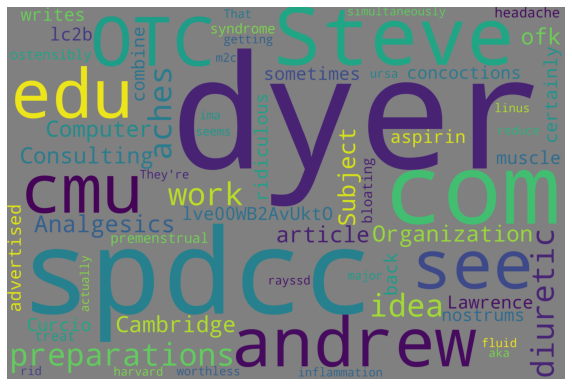

In [87]:
plt.figure(figsize=(10, 12))
plt.imshow(wc_im) 
plt.axis("off")
plt.show()

#### Scattertext

In [88]:
import scattertext as st
import spacy
#!python -m spacy download en
#!python -m spacy download de_core_news_sm

In [89]:
nlp_d = spacy.load('de_core_news_sm')

In [90]:
sentence = nlp_d("Ich komme aus Rusland.")
print([(w.text, w.pos_) for w in sentence])

[('Ich', 'PRON'), ('komme', 'VERB'), ('aus', 'ADP'), ('Rusland', 'PROPN'), ('.', 'PUNCT')]


In [91]:
speach_df = st.SampleCorpora.ConventionData2012.get_data()  

In [94]:
speach_df.shape

(189, 3)

In [95]:
nlp = spacy.load('en_core_web_sm')

In [96]:
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

[('This', 'DET'), ('is', 'AUX'), ('a', 'DET'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


In [97]:
corpus = st.CorpusFromPandas(speach_df, 
                              category_col='party', 
                              text_col='text',
                            nlp=nlp).build()

In [98]:
list(corpus.get_scaled_f_scores_vs_background().index[:10])

['obama',
 'romney',
 'barack',
 'mitt',
 'obamacare',
 'biden',
 'romneys',
 'hardworking',
 'bailouts',
 'autoworkers']

In [107]:
term_freq_df = corpus.get_term_freq_df()

In [104]:
term_freq_df['Democratic Score'] = corpus.get_scaled_f_scores('democrat')
print(list(term_freq_df.sort_values(by='Democratic Score', ascending=False).index[:10]))

['middle class', 'forward', 'class', 'middle', 'the middle', 'pay', 'medicare', 'education', 'health', 'president obama']


In [108]:
term_freq_df['Democratic Score'] = corpus.get_scaled_f_scores('republican')
print(list(term_freq_df.sort_values(by='Democratic Score', ascending=False).index[:10]))

['government', 'administration', 'business', 'can do', 'success', 'story', 'unemployment', 'freedom', 'paul', 'do better']


In [109]:
html = st.produce_scattertext_explorer(corpus,
          category='democrat',
          category_name='Democratic',
          not_category_name='Republican',
          width_in_pixels=1000,
          metadata=speach_df['speaker'])

open("my_best_vis.html", 'wb').write(html.encode('utf-8'))

1682162

### Задача предсказания длительности позедки такси

Нагенерируем признаков, чтобы улучшить качество предсказаия Xgboost.

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Сохраним названия исходных признаков, чтобы затем сравнивать качество.

In [9]:
old_features = list(train.columns)

Выделим переменную, которую хотим предсказывать — trip_duration.

In [11]:
y = train.trip_duration

Описание данных:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

In [12]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['pickup_date'] = train['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = train.store_and_fwd_flag == 'Y'

In [13]:
test['store_and_fwd_flag'] = test.store_and_fwd_flag == 'Y'
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

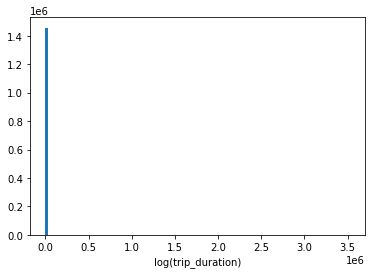

In [15]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('')
plt.show()

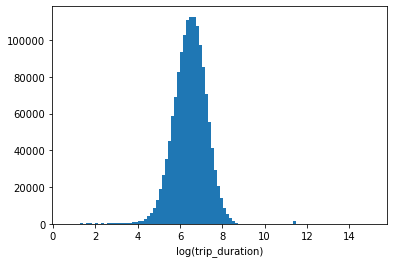

In [16]:
plt.hist(np.log(train['trip_duration'].values+1), bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('')
plt.show()

Если решаете соревнование, может быть ползеным проверить, насколко трэйн похож на тест

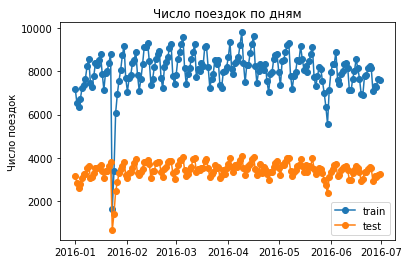

In [17]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Число поездок по дням')
plt.legend()
plt.ylabel('Число поездок')
plt.show()

### Welcome to NY

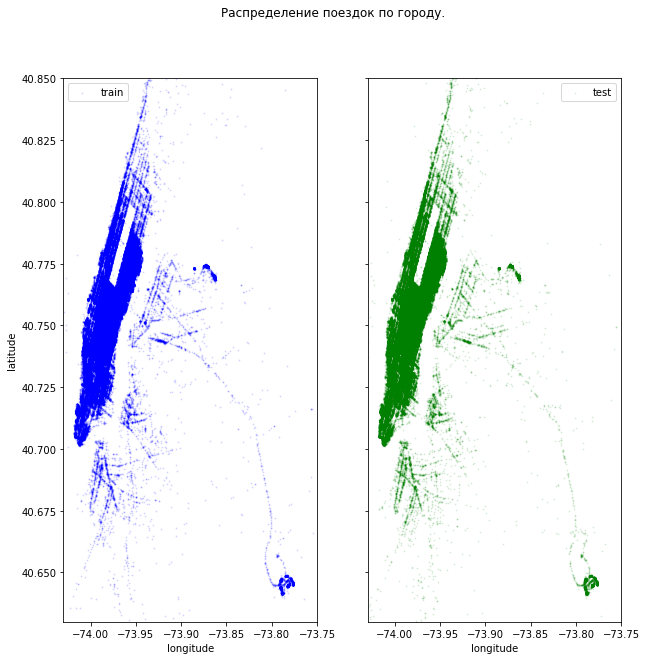

In [20]:
N = 20**4
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Распределение поездок по городу.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Можно добавть разные расстояния.

[Haversine_formula](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    r = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * r * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b


In [21]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

Признаки из дат.

In [22]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

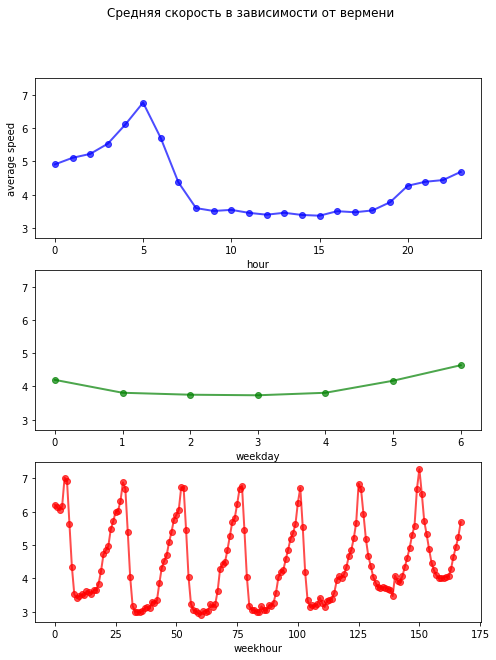

In [27]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

fig, ax = plt.subplots(nrows=3, sharey=True, figsize=(8, 10))
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Средняя скорость в зависимости от вермени')
plt.show()

Обучим модели на старых и старых+новых признаках.

In [28]:
drop_f = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'pickup_date', 'avg_speed_h', 'avg_speed_m']
feature_names = [f for f in train.columns if f not in drop_f]
old_feat = [f for f in old_features if f not in drop_f]

In [29]:
y_log = np.log(y + 1)

In [30]:
Xtr, Xv, ytr, yv = train_test_split(train[old_feat].values, y_log, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[old_feat].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse'}

In [ ]:
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

In [ ]:
print('RMSE %.5f' % model.best_score)

In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y_log, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]


In [ ]:
model2 = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

In [ ]:
print('RMSE %.5f' % model2.best_score)